# **AutoDriveRL**
- Author: Kim Dohwan [@ehghks021203](https://github.com/ehghks021203)
- Date: 2024.03.14. ~
- Description: DQN 알고리즘을 활용한 자율주행 모델 개발

여기서는 CARLA Simulation 클라이언트를 사용하여 자율주행 모델을 학습하는 과정을 설명합니다. 우리는 DQN(Deep Q-Network) 알고리즘을 사용하여 자율주행 에이전트를 학습시키며, CNN과 GRU가 결합된 멀티모달 신경망인 MixxNet을 모델로 활용합니다.


## **Abstract**

자율주행 에이전트를 개발하고 학습시키는 것은 복잡한 과제입니다. 여기서는 다음과 같은 목표를 달설하기 위해 DQN 알고리즘을 활용한 자율주행 에이전트를 학습합니다.


## **Objective and Significance**
1. **장애물 회피:** 에이전트가 도로 상의 장애물을 인식하고 피할 수 있도록 합니다.
2. **차선 유지:** 에이전트가 주어진 차선을 유지하며 주행할 수 있도록 합니다.
3. **신호 준수:** 에이전트가 교통 신호를 인식하고 이를 준수할 수 있도록 합니다.
4. **빠른 주행:** 안전한 범위 내에서 가능한 빠르게 주행하도록 합니다.


## **Neural Network Struct**
### **MixxNet**

MixxNet은 이미지 데이터를 처리하는 CNN과 경로 데이터를 처리하는 GRU로 구성된 멀티모달 신경망입니다. 이 네트워크는 다음과 같은 구조를 가집니다.

- **CNN:** 이미지 데이터를 입력받아 특징을 추출합니다.
- **GRU:** 경로 데이터를 입력받아 시퀀스 정보를 처리합니다.

위 두 신경망의 출력을 결합하여 최종 예측을 수행합니다.


## **DQN Algorithm**

DQN 알고리즘은 강화 학습의 한 종류로, 에이전트가 환경과 상호작용하며 최적의 행동 정책을 학습합니다. 이 알고리즘은 다음과 같은 주요 단계로 구성됩니다.

1. **상태(state):** 에이전트가 현재 인식한 환경의 정보입니다.
2. **행동(action):** 에이전트가 취할 수 있는 행동입니다.
3. **보상(reward):** 에이전트가 특정 행동을 취했을 때 환경으로부터 받는 피드백입니다.
4. **정책(policy):** 에이전트가 각 상태에서 어떤 행동을 취할지 결정하는 전략입니다.


## **Reward Functions**

에이전트의 목적을 달성하기 위해 보상 함수를 설정합니다. 보상 함수는 에이전트가 다음의 목표를 달설할 때 높은 보상을 받도록 설계됩니다.

- 장애물을 피할 때 보상 증가
- 차선을 유지할 때 보상 증가
- 교통 신호를 준수할 때 보상 증가
- 안전하게 빠르게 주행할 때 보상 증가



In [1]:
# Add file path
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))

## **2. CARLA 클라이언트 및 월드 설정**
### **CARLA 클라이언트 설정**

이 CARLA Simulator 클라이언트를 초기화하고, 서버와의 연결을 설정합니다.

- Client Host: `localhost`
- Client Port: `2000`

In [2]:
import carla

client = carla.Client("localhost", 2000)
client.set_timeout(10)

### **월드 및 맵 데이터 설정**

시뮬레이션 월드를 로드하고, 맵 데이터를 가져오며, 블루프린트 라이브러리를 불러옵니다.

In [3]:
# Set world
world = client.load_world("Town04_Opt")
world.unload_map_layer(carla.MapLayer.Decals)

# Get map data
map = world.get_map()

# Get blueprint library
blueprint_library = world.get_blueprint_library()

## **3. Agent and Waypoint class declarations**

### **Agent 클래스**

에이전트(Agent) 클래스는 자율주행 차량의 생성 및 제어를 담당합니다. 이 클래스는 차량의 초기화, 제어 명령 적용, 센서 데이터 처리 등을 포함합니다.


In [4]:
import time
import math
import numpy as np

class Agent():
    waypoint = None
    def __init__(self, waypoint) -> None:
        # Initialize actor list
        self.actor_list = []
        
        # Set vehicle spawn point
        transform = waypoint.start_point
        self.waypoint = waypoint
        self.vehicle_model = blueprint_library.filter("vehicle.mini.cooper_s_2021")[0]

        # Spawning the vehicle
        self.vehicle = world.spawn_actor(self.vehicle_model, transform)
        self.actor_list.append(self.vehicle)
        
        # Attach Camera with Vehicle
        self.rgb_cam = world.spawn_actor(
            blueprint_library.find('sensor.camera.rgb'),
            carla.Transform(carla.Location(x=1.5, z=2.4), carla.Rotation(pitch=-15)),
            attach_to=self.vehicle)
        self.actor_list.append(self.rgb_cam)

        # Observer Camera
        self.observe_cam = world.spawn_actor(
            blueprint_library.find('sensor.camera.rgb'),
            carla.Transform(carla.Location(x=-1.5, z=17.8), carla.Rotation(pitch=-90)),
            attach_to=self.vehicle)
        self.actor_list.append(self.observe_cam)
        
        # Attach Collision Sensor with Vehicle
        self.collision_sensor = world.spawn_actor(
            blueprint_library.find('sensor.other.collision'),
            carla.Transform(),
            attach_to=self.vehicle
        )
        self.actor_list.append(self.collision_sensor)

        self.target_speed = 30

    def get_route(self, max_point=10, draw=False, to_list=True):
        if not waypoint:
            raise RuntimeError("Waypoint does not exist")
        agent_location = self.get_location()
        waypoint_data = []
        min_dist = 99999999
        min_idx = 0
        for i in range(len(waypoint.waypoints)):
            x = waypoint.waypoints[i][0].transform.location.x - agent_location.x
            y = waypoint.waypoints[i][0].transform.location.y - agent_location.y
            waypoint_data.append([x, y])
            dist = math.sqrt(x**2 + y**2)
            if min_dist > dist:
                min_dist = dist 
                min_idx = i
        if draw:
            first_point = True
            for w in waypoint.waypoints[min_idx:min_idx+max_point]:
                if first_point:
                    world.debug.draw_string(
                        w[0].transform.location, 
                        'O', 
                        draw_shadow=False,
                        color=carla.Color(r=0, g=255, b=0), 
                        life_time=0.2,
                        persistent_lines=True
                    )
                    first_point = False
                else:
                    world.debug.draw_string(
                        w[0].transform.location, 
                        'O', 
                        draw_shadow=False,
                        color=carla.Color(r=255, g=0, b=0), 
                        life_time=0.2,
                        persistent_lines=True
                    )

        if to_list:
            return np.array(waypoint_data[min_idx:min_idx+max_point])
        else:
            return waypoint.waypoints[min_idx:min_idx+max_point]

    def get_travel_distance(self):
        if not waypoint:
            raise RuntimeError("Waypoint does not exist")
        agent_location = self.get_location()
        min_dist = 99999999
        min_idx = 0
        for i in range(len(waypoint.waypoints)):
            x = waypoint.waypoints[i][0].transform.location.x - agent_location.x
            y = waypoint.waypoints[i][0].transform.location.y - agent_location.y
            dist = math.sqrt(x**2 + y**2)
            if min_dist > dist:
                min_dist = dist 
                min_idx = i
        return min_idx / len(waypoint.waypoints)

    def get_location(self):
        return self.vehicle.get_location()

    def get_transform(self):
        return self.vehicle.get_transform()

    def get_speed(self):
        """
        Compute speed of a vehicle in Km/h.
            :param vehicle: the vehicle for which speed is calculated
            :return: speed as a float in Km/h
        """
        vel = self.vehicle.get_velocity()
    
        return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)

    def apply_control(self, throttle, brake, steer):
        self.vehicle.apply_control(carla.VehicleControl(throttle=throttle, brake=brake, steer=steer))

    def set_waypoint(self, waypoint):
        self.waypoint = waypoint

    def process_img(self, image, dim_x=128, dim_y=128):
        array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        array = np.reshape(array, (image.height, image.width, 4))
        array = array[:, :, :3]
        array = array[:, :, ::-1]
    
        dim = (dim_x, dim_y)  # set same dim for now
        resized_img = cv2.resize(array, dim, interpolation=cv2.INTER_AREA)
        img_gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        scaledImg = img_gray/255.
    
        # normalize
        mean, std = 0.5, 0.5
        normalizedImg = (scaledImg - mean) / std
    
        return normalizedImg

    def collision_data(self, event):
        lane_types = set(x.type for x in event.crossed_lane_markings)
        text = ['%r' % str(x).split()[-1] for x in lane_types]
        print('Crossed line %s' % ' and '.join(text))

    def destroy(self):
        for actor in self.actor_list:
            actor.destroy()

### **Waypoint 클래스**

웨이포인트(Waypoint) 클래스는 경로 데이터를 생성하고 관리합니다. 이 클래스는 시작점과 끝점을 설정하고, 경로를 추적하여 웨이포인트 리스트를 생성합니다.

In [5]:
from src.agents.navigation.global_route_planner import GlobalRoutePlanner

class Waypoint():
    def __init__(self, stt_point=10, end_point=20):
        self.sampling_resolution = 2
        self.grp = GlobalRoutePlanner(map, self.sampling_resolution)
        spawn_points = map.get_spawn_points()
        
        self.start_point = spawn_points[stt_point]
        self.end_point = spawn_points[end_point]
        self.start_point_location = carla.Location(self.start_point.location)
        self.end_point_location = carla.Location(self.end_point.location)
        self.waypoints = self.grp.trace_route(self.start_point_location, self.end_point_location)

    def render(self):
        i = 0
        for w in self.waypoints:
            if i % 10 == 0:
                world.debug.draw_string(
                    w[0].transform.location, 
                    'O', 
                    draw_shadow=False,
                    color=carla.Color(r=255, g=0, b=0), 
                    life_time=2.0,
                    persistent_lines=True
                )
            else:
                world.debug.draw_string(
                    w[0].transform.location, 
                    'O', 
                    draw_shadow=False,
                    color = carla.Color(r=0, g=0, b=255), 
                    life_time=2.0,
                    persistent_lines=True
                )
            time.sleep(0.05)
            i += 1

    def show_spawn_points(self):
        spawn_points = map.get_spawn_points()
        for i in range(len(spawn_points)):
            world.debug.draw_string(
                spawn_points[i].location, 
                f'{i}', 
                draw_shadow=False,
                color=carla.Color(r=255, g=0, b=0), 
                life_time=2.0,
                persistent_lines=True
            )

In [6]:
# waypoint.show_spawn_points()

In [7]:
# Initialize agent list

agent_list = []

In [8]:
waypoint = Waypoint(stt_point=12, end_point=285)
agent = Agent(waypoint)
agent_list.append(agent)

In [9]:
# Show waypoint route
waypoint.render()

In [10]:
# Show agent route
agent.get_route(draw=True)

array([[-1.52587891e-05,  0.00000000e+00],
       [-1.52587891e-05,  0.00000000e+00],
       [-1.99998474e+00,  1.03149414e-02],
       [-3.99995422e+00,  2.06298828e-02],
       [-5.99993896e+00,  3.09143066e-02],
       [-7.99990845e+00,  4.12292480e-02],
       [-9.99987793e+00,  5.15441895e-02],
       [-1.19998474e+01,  6.18591309e-02],
       [-1.39998322e+01,  7.21435547e-02],
       [-1.59998016e+01,  8.24584961e-02]])

In [11]:
a = agent.get_route(to_list=False)

In [12]:
a[0][0].transform.rotation.yaw

179.70469665527344

In [13]:
# agent.destroy()

## **MixxNet: Multi-Modal Neural Network for Autonomous Driving**

`MixxNet` 모델은 이미지 데이터와 경로 데이터를 각각 `CNN`과 `GRU`를 통해 처리한 후, 이를 결합하여 최종 출력을 생성합니다.

<br/>

### Model Structure
`MixxNet`은 이미지 데이터를 처리하는 `CNN`과 경로 데이터를 처리하는 `GRU`로 구성됩니다. 이 두 출력을 결합하여 전결합층(Fully-Connected Layer)을 통해 최종 예측을 수행합니다.

### Input Parameters
- `num_actions`: 신경망의 출력 차원
- `in_channels`: 입력 이미지의 채널 수
- `input_size`: 각 입력 벡터의 크기
- `hidden_size`: GRU의 은닉 상태 벡터 크기
- `num_layers`: GRU의 레이어 수
- `seq_length`: 입력 시퀀스의 길이


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MixxNet(nn.Module):
    def __init__(self, num_actions, in_channels, input_size, hidden_size, num_layers, seq_length) -> None:
        # Parameter summary
        # num_actions : 신경망의 출력 차원 (액션 개수)
        # in_channels : 입력 이미지의 채널 수
        #  input_size : 각 입력 벡터의 크기
        # hidden_size : GRU의 은닉 상태 벡터 크기
        #  num_layers : GRU의 레이어 수
        #  seq_length : 입력 시퀀스의 길이
        
        super(MixxNet, self).__init__()

        # CNN for image data
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1),
            nn.ReLU()
        )
            
        # Flatten CNN output
        self.cnn_fc = nn.Linear(64, 512)

        # GRU for waypoint data
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected layers
        self.fc_layer1 = nn.Sequential(
            nn.Linear(640, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.fc_layer2 = nn.Sequential(
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.fc_layer3 = nn.Sequential(
            nn.Linear(32, num_actions),
            nn.Sigmoid()
        )

    
    def forward(self, image_data, waypoint_data):
        # CNN forward pass
        cnn_out = self.cnn(image_data)
        cnn_out = cnn_out.view(cnn_out.size(0), -1)  # Flatten
        cnn_out = F.relu(self.cnn_fc(cnn_out))
        
        # GRU forward pass
        h_0 = torch.zeros(self.gru.num_layers, waypoint_data.size(0), self.gru.hidden_size).to(waypoint_data.device)
        gru_out, _ = self.gru(waypoint_data, h_0)
        gru_out = gru_out[:, -1, :]  # Take the output of the last time step
        
        # Combine CNN and GRU outputs
        combined = torch.cat((cnn_out, gru_out), dim=1)
        
        # Fully connected layers
        x = self.fc_layer1(combined)
        x = self.fc_layer2(x)
        output = self.fc_layer3(x)
        
        return output

## **DQNAgent with MixxNet**

자율주행에 발생하는 복잡한 제어 문제를 해결하기 위해 DQN 에이전트를 사용합니다.
앞서 구성한 `MixxNet`을 사용하여 이미지 데이터와 경로 데이터를 처리합니다.

<br/>

### Model Structure
`DQNAgent`는 Deep Q-Network 알고리즘을 기반으로 하는 에이전트입니다. 이 에이전트는 `MixxNet`을 사용하여 상태를 입력으로 받아 최적의 행동을 출력합니다.

### MixxNet
`MixxNet`은 이미지 데이터를 처리하는 CNN과 경로 데이터를 처리하는 GRU로 구성됩니다. 두 출력을 결합하여 최종 예측을 수행합니다.

### DQNAgent Functions
#### 1. 모델 초기화 (`__init__`)
- 모델의 하이퍼파라미터를 설정합니다.
- MixxNet을 Q Network로 초기화하고, 이를 복사하여 타겟 네트워크를 만듭니다.
- 옵티마이저를 설정합니다.

#### 2. 액션 선택 함수 (`select_action`)
- 현재 상태에서 최적의 행동을 선택합니다.
- `eval`이 `True`인 경우, 평가 모드에서 행동을 선택합니다.
- Epsilon-greedy 정책을 사용하여 행동을 선택합니다.

#### 3. 학습 함수 (`train`)
- 리플레이 메모리에서 미니배치를 샘플링하여 네트워크를 학습시킵니다.
- 현재 Q 값과 타겟 Q 값을 계산하여 손실을 구합니다.
- 옵티마이저를 사용하여 손실을 최소화합니다.
- 일정 주기마다 타겟 네트워크를 업데이트합니다.

#### 4. 타겟 네트워크 업데이트 함수 (`copy_target_update`)
- 일정 주기마다 타겟 네트워크를 Q 네트워크의 가중치로 업데이트합니다.

#### 5. 모델 저장 함수 (`save`)
- Q 네트워크와 옵티마이저 상태를 저장합니다.

#### 6. 모델 로드 함수 (`load`)
- 저장된 Q 네트워크와 옵티마이저 상태를 불러옵니다.


In [15]:
import copy

class DQNAgent(object):
    def __init__(
        self,
        num_actions,
        in_channels,
        waypoint_dim,
        device,
        discount=0.9,
        optimizer="Adam",
        optimizer_parameters={'lr':0.01},
        target_update_frequency=1e4,
        initial_eps=1,
        end_eps=0.05,
        eps_decay_period=25e4,
        eval_eps=0.001
    ) -> None:
        # Set Device
        self.device = device
        self.num_actions = num_actions

        # Initialize MixxNet as Q network
        self.Q = MixxNet(
            num_actions=num_actions,  # Output for throttle, brake, and steer
            in_channels=in_channels, 
            input_size=2, 
            hidden_size=128,
            num_layers=2,
            seq_length=10
        ).to(self.device)
        self.Q_target = copy.deepcopy(self.Q)  # Copy target network
        self.Q_optimizer = getattr(torch.optim, optimizer)(self.Q.parameters(), **optimizer_parameters)

        self.discount = discount
        self.target_update_frequency = target_update_frequency
 
        # Epsilon decay
        self.initial_eps = initial_eps
        self.end_eps = end_eps
        self.slope = (self.end_eps - self.initial_eps) / eps_decay_period

        self.state_shape = (in_channels, 128, 128)  # Example image shape
        self.eval_eps = eval_eps
        self.iterations = 0

    def select_action(self, image_state, waypoint_state, eval=False):
        eps = self.eval_eps if eval else max(self.slope * self.iterations + self.initial_eps, self.end_eps)
        self.current_eps = eps

        # Select action according to policy with probability (1-eps)
        # Otherwise, select random action
        if np.random.uniform(0, 1) > eps:
            self.Q.eval()
            with torch.no_grad():
                image_state = torch.FloatTensor(image_state).reshape(self.state_shape).unsqueeze(0).to(self.device)
                waypoint_state = torch.FloatTensor(waypoint_state).unsqueeze(0).to(self.device)
                # Assuming image_state has shape [128, 128] and needs to be reshaped to [1, 1, 128, 128]
                # image_state = torch.FloatTensor(image_state).unsqueeze(0).to(self.device)
                # Assuming waypoint_state has shape [waypoint_dim]
                # waypoint_state = torch.FloatTensor(waypoint_state).to(self.device)
                return int(self.Q(image_state, waypoint_state).argmax(1))
        else:
            return np.random.randint(self.num_actions)

    def train(self, replay_memory):
        self.Q.train()
        image_state, waypoint_state, action, next_image_state, next_waypoint_state, reward, done = replay_memory.sample()

        action = action.clone().detach().long()

        with torch.no_grad():
            target_Q = reward + (1 - done) * self.discount * self.Q_target(next_image_state, next_waypoint_state).max(1, keepdim=True)[0]

        # Get current Q estimate
        # torch gather just selects action values from Q(state) using the action tensor as an index
        current_Q = self.Q(image_state, waypoint_state).gather(1, action)

        # Compute Q loss
        Q_loss = F.smooth_l1_loss(current_Q, target_Q)

        # Optimize the Q
        self.Q_optimizer.zero_grad()
        Q_loss.backward()
        self.Q_optimizer.step()

        # Update target network by full copy every X iterations.
        self.iterations += 1
        self.copy_target_update()

    def copy_target_update(self):
        if self.iterations % self.target_update_frequency == 0:
            print('target network updated')
            print('current epsilon', self.current_eps)
            self.Q_target.load_state_dict(self.Q.state_dict())

    def save(self, filename):
        torch.save(self.Q.state_dict(), filename + "_Q")
        torch.save(self.Q_optimizer.state_dict(), filename + "_optimizer")

    def load(self, filename):
        self.Q.load_state_dict(torch.load(filename + "_Q"))
        self.Q_target = copy.deepcopy(self.Q)
        self.Q_optimizer.load_state_dict(torch.load(filename + "_optimizer"))


## **Replay memory**

In [16]:
class ReplayMemory(object):
    def __init__(
        self,
        image_dim,
        waypoint_dim,
        batch_size,
        buffer_size,
        device
    ) -> None:
        self.batch_size = batch_size
        self.max_size = int(buffer_size)
        self.device = device

        self.ptr = 0
        self.crt_size = 0

        # Initialize buffers
        self.image_state = np.zeros((self.max_size,) + image_dim)
        self.waypoint_state = np.zeros((self.max_size,) + waypoint_dim)
        self.action = np.zeros((self.max_size, 3))
        self.next_image_state = np.zeros((self.max_size,) + image_dim)
        self.next_waypoint_state = np.zeros((self.max_size,) + waypoint_dim)
        self.reward = np.zeros((self.max_size, 1))
        self.done = np.zeros((self.max_size, 1))

    def add(self, image_state, waypoint_state, action, next_image_state, next_waypoint_state, reward, done):
        self.image_state[self.ptr] = image_state
        self.waypoint_state[self.ptr] = waypoint_state
        self.action[self.ptr] = action
        self.next_image_state[self.ptr] = next_image_state
        self.next_waypoint_state[self.ptr] = next_waypoint_state
        self.reward[self.ptr] = reward
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.crt_size = min(self.crt_size + 1, self.max_size)

    def sample(self):
        ind = np.random.randint(0, self.crt_size, size=self.batch_size)
        return (
            torch.FloatTensor(self.image_state[ind]).unsqueeze(1).to(self.device),
            torch.FloatTensor(self.waypoint_state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_image_state[ind]).unsqueeze(1).to(self.device),
            torch.FloatTensor(self.next_waypoint_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.done[ind]).to(self.device)
        )


## **Reward Function**

In [17]:
def get_reward_comp(vehicle, waypoint, collision):
    vehicle_location = vehicle.get_location()
    x_wp = waypoint[1][0].transform.location.x
    y_wp = waypoint[1][0].transform.location.y

    x_vh = vehicle_location.x
    y_vh = vehicle_location.y

    wp_array = np.array([x_wp, y_wp])
    vh_array = np.array([x_vh, y_vh])

    dist = np.linalg.norm(wp_array - vh_array)

    vh_yaw = correct_yaw(vehicle.get_transform().rotation.yaw)
    wp_yaw = correct_yaw(waypoint[1][0].transform.rotation.yaw)
    cos_yaw_diff = np.cos((vh_yaw - wp_yaw)*np.pi/180.)

    collision = 0 if collision is None else 1

    travel_distance = vehicle.get_travel_distance()

    speed = -1 if vehicle.get_speed() <= 20 else 1

    reward = cos_yaw_diff - dist - (3 * collision) + speed + (5 * travel_distance)
    
    return reward, collision

def correct_yaw(x):
    return(((x%360) + 360) % 360)


In [18]:
# dqn action values
action_values = [
    (1.00, 0.00, -0.75), 
    (1.00, 0.00, -0.50), 
    (1.00, 0.00, -0.25), 
    (1.00, 0.00, -0.15), 
    (1.00, 0.00, -0.10), 
    (1.00, 0.00, -0.05), 
    (1.00, 0.00, 0.00),
    (1.00, 0.00, 0.05), 
    (1.00, 0.00, 0.10),
    (1.00, 0.00, 0.50), 
    (1.00, 0.00, 0.75), 
    (0.50, 0.00, -0.75), 
    (0.50, 0.00, -0.50), 
    (0.50, 0.00, -0.25), 
    (0.50, 0.00, -0.15), 
    (0.50, 0.00, -0.10), 
    (0.50, 0.00, -0.05), 
    (0.50, 0.00, 0.00),
    (0.50, 0.00, 0.05), 
    (0.50, 0.00, 0.10),
    (0.50, 0.00, 0.50), 
    (0.00, 0.50, 0.75), 
    (0.00, 0.50, -0.50), 
    (0.00, 0.50, -0.25), 
    (0.00, 0.50, -0.15), 
    (0.00, 0.50, -0.10), 
    (0.00, 0.50, -0.05), 
    (0.00, 0.50, 0.00),
    (0.00, 0.50, 0.05), 
    (0.00, 0.50, 0.10),
    (0.00, 0.50, 0.50), 
    (0.00, 0.50, 0.75), 
]

# dqn action values
action_values = [
    (1.00, 0.00, -0.75), 
    (1.00, 0.00, -0.50), 
    (1.00, 0.00, -0.25), 
    (1.00, 0.00, -0.15), 
    (1.00, 0.00, -0.10), 
    (1.00, 0.00, -0.05), 
    (1.00, 0.00, 0.00),
    (1.00, 0.00, 0.05), 
    (1.00, 0.00, 0.10),
    (1.00, 0.00, 0.50), 
    (1.00, 0.00, 0.75), 
    (0.50, 0.00, -0.75), 
    (0.50, 0.00, -0.50), 
    (0.50, 0.00, -0.25), 
    (0.50, 0.00, -0.15), 
    (0.50, 0.00, -0.10), 
    (0.50, 0.00, -0.05), 
    (0.50, 0.00, 0.00),
    (0.50, 0.00, 0.05), 
    (0.50, 0.00, 0.10),
    (0.50, 0.00, 0.50),
    (0.25, 0.00, -0.75), 
    (0.25, 0.00, -0.50), 
    (0.25, 0.00, -0.25), 
    (0.25, 0.00, -0.15), 
    (0.25, 0.00, -0.10), 
    (0.25, 0.00, -0.05), 
    (0.25, 0.00, 0.00),
    (0.25, 0.00, 0.05), 
    (0.25, 0.00, 0.10),
    (0.25, 0.00, 0.50),
]
action_map = {i:x for i, x in enumerate(action_values)}

In [19]:
params = {
    "train_freq": 5,
    "save_freq": 100,
    "start_ep": 0,
    "start_buffer": 10,
}

pygame 2.5.2 (SDL 2.28.3, Python 3.8.1)
Hello from the pygame community. https://www.pygame.org/contribute.html
Episode    0 processed   182 | reward: -328.9918319400684
Episode    1 processed   161 | reward: -284.11322220119007
Episode    2 processed   190 | reward: -346.7622873477827
Episode    3 processed   215 | reward: -401.25326154521747
Episode    4 processed   211 | reward: -379.4538469953542
Episode    5 processed   207 | reward: -294.9558152690994
Episode    6 processed   158 | reward: -264.53677216011386
Episode    7 processed   195 | reward: -337.639846680073
Episode    8 processed   164 | reward: -279.8305283632183
Episode    9 processed   206 | reward: -369.1735387765902
Episode   10 processed   171 | reward: -295.61360325053806


C:\Users\ehghk\AppData\Local\Temp\ipykernel_34060\764803172.py:80: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  Q_loss = F.smooth_l1_loss(current_Q, target_Q)


Episode   11 processed   220 | reward: -382.83874417412875
Episode   12 processed   192 | reward: -346.6608180378392
Episode   13 processed   209 | reward: -388.9821715100619
Episode   14 processed   147 | reward: -264.29287531934176
Episode   15 processed   212 | reward: -385.66130564433695
Episode   16 processed   221 | reward: -388.9746411655841
Episode   17 processed   322 | reward: -557.3443473340392
Episode   18 processed   204 | reward: -381.15809941860084
Episode   19 processed   154 | reward: -268.9556530303442
Episode   20 processed   183 | reward: -326.5946227588702
Episode   21 processed   177 | reward: -314.5934988342641
Episode   22 processed   183 | reward: -298.32959644659945
Episode   23 processed   259 | reward: -474.42446371133025
Episode   24 processed   194 | reward: -359.2579702504359
Episode   25 processed   214 | reward: -367.4498554988005
Episode   26 processed   242 | reward: -430.6492758514644
Episode   27 processed   206 | reward: -384.3845133604152
Episode 

KeyboardInterrupt: 

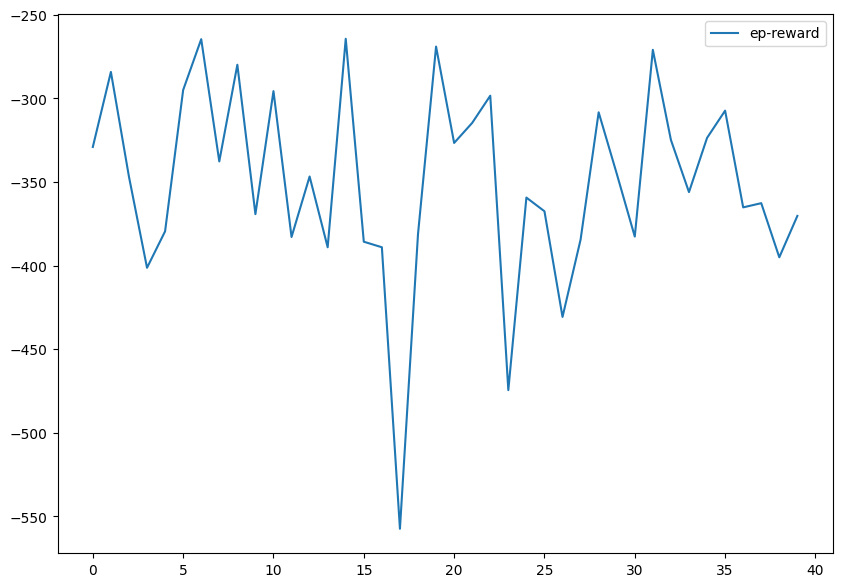

In [20]:
import cv2
import pygame
import matplotlib.pyplot as plt
import seaborn as sns
from src.synchronous_mode import CarlaSyncMode

try:
    buffer_size = 1e4
    batch_size = 16
    episodes = 5000
    image_dim = (128, 128)
    waypoint_dim = (10, 2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_actions = len(action_values)
    in_channels = 1

    # Set replay memory and model
    replay_memory = ReplayMemory(image_dim, waypoint_dim, batch_size, buffer_size, device)
    model = DQNAgent(
        num_actions=num_actions,
        in_channels=in_channels,
        waypoint_dim=waypoint_dim,
        device=device
    )

    # this only works if you have a model in your weights folder. Replace this by that file
    # model.load('../weights/model_ep_1400')

    g_time = 0
    start_train = params["start_ep"] + params["start_buffer"]
    total_rewards = 0
    average_rewards_list = []
    ep_reward_list = []

    for ep in range(episodes):
        with CarlaSyncMode(world, agent.rgb_cam, agent.observe_cam, agent.collision_sensor, fps=30) as sync_mode:
            # Initialize agent step count
            step_count = 0
            ep_reward = 0
        
            # Get state from world
            snapshot, image_rgb, image_observe, collision = sync_mode.tick(timeout=2.0)
            
            # destroy if there is no data
            if snapshot is None or image_rgb is None:
                print("No data, skipping episode")
                self.reset()
                continue
            
            image_data = agent.process_img(image_rgb)
            waypoint_data = agent.get_route()
            next_image_state = image_data
            next_waypoint_state = waypoint_data
        
            while True:
                # Get vehicle state
                agent_location = agent.get_location()
                speed = agent.get_speed()
        
                # Render waypoint every 10 step count
                if step_count % 10 == 0:
                    agent_route = agent.get_route(draw=True, to_list=False)
                else:
                    agent_route = agent.get_route(to_list=False)
        
                # Advance the simulation and wait for the data.
                image_state = next_image_state
                waypoint_state = next_waypoint_state
        
                step_count += 1
                g_time += 1
        
                action = model.select_action(image_state, waypoint_state)
                throttle, brake, steer = action_map[action]
                # print(throttle, brake, steer)
        
                #############
                
                # Select action based on state(rgb camera)
                agent.apply_control(throttle, brake, steer)
        
                fps = round(1.0 / snapshot.timestamp.delta_seconds)
        
                snapshot, image_rgb, image_observe, collision = sync_mode.tick(timeout=2.0)
        
                reward, collision = get_reward_comp(agent, agent_route, collision)
        
                if snapshot is None or image_rgb is None:
                    print("Process ended here")
                    break
        
                image_data = agent.process_img(image_rgb)
                waypoint_data = agent.get_route()
        
                done = 1 if collision else 0
        
                total_rewards += reward
                ep_reward += reward
        
                next_image_state = image_data
                next_waypoint_state = waypoint_data
        
                replay_memory.add(image_state, waypoint_state, action, next_image_state, next_waypoint_state, reward, done)
        
                
                if ep > start_train and (g_time % params["train_freq"]) == 0:
                    model.train(replay_memory)
        
                if collision == 1 or step_count >= 1000:
                    ep_reward_list.append(ep_reward)
                    print("Episode {:4d} processed {:5d} | reward: {}".format(ep, step_count, ep_reward))
                    break
                    
            if ep % params["save_freq"] == 0 and ep > params["start_ep"]:
                avg_reward = total_rewards/ep
                average_rewards_list.append(avg_reward)
                total_rewards = 0
        
                model.save("../weights/model_ep_{}".format(ep))
        
                print("Saved model with average reward =", avg_reward)
        # Environment reset
        # reset actor list
        for agent in agent_list:
            agent.destroy()

        agent_list = []
        
        # Create Waypointss

        # Create vehicle actor
        agent = Agent(waypoint)
        agent_list.append(agent)

        # Reset global timestep
        g_time = 0
finally:
    print("=== END ===")
    plt.subplots(figsize=(10, 7))
    sns.lineplot(ep_reward_list, label="ep-reward")

